# Example Instrumental Variable Modelling (IV) with `pymc` models

This notebook shows an example of using instrumental variable regression.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
from patsy import build_design_matrices, dmatrices
from statsmodels.formula.api import ols

import causalpy as cp
from causalpy.pymc_experiments import ExperimentalDesign
from causalpy.pymc_models import ModelBuilder

In [2]:
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'svg'
seed = 42

In [3]:
iv_df = pd.read_csv("AJR2001.txt", sep="\t")
iv_df

,longname,shortnam,logmort0,risk,loggdp,campaign,source0,slave,latitude,neoeuro,...,logmortjam,logmortcap250,logmortjam250,wandcafrica,malfal94,wacacontested,mortnaval2250,logmortnaval2250,mortnaval1250,logmortnaval1250
0,Angola,AGO,5.634790,5.36,7.77,1,0,0,0.1367,0,...,5.634790,5.521461,5.521461,1,0.95000,1,250.000000,5.521461,250.000000,5.521461
1,Argentina,ARG,4.232656,6.39,9.13,1,0,0,0.3778,0,...,4.034241,4.232656,4.034241,0,0.00000,0,30.500000,3.417727,15.070000,2.712706
2,Australia,AUS,2.145931,9.32,9.90,0,0,0,0.3000,1,...,2.145931,2.145931,2.145931,0,0.00000,0,8.550000,2.145931,8.550000,2.145931
3,Burkina Faso,BFA,5.634790,4.45,6.85,1,0,0,0.1444,0,...,5.634790,5.521461,5.521461,1,0.95000,1,250.000000,5.521461,250.000000,5.521461
4,Bangladesh,BGD,4.268438,5.14,6.88,1,1,0,0.2667,0,...,4.268438,4.268438,4.268438,0,0.12008,0,71.410004,4.268438,71.410004,4.268438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,USA,USA,2.708050,10.00,10.22,0,1,0,0.4222,1,...,2.708050,2.708050,2.708050,0,0.00000,0,15.000000,2.708050,15.000000,2.708050
60,Venezuela,VEN,4.357990,7.14,9.07,1,0,0,0.0889,0,...,4.130355,4.357990,4.130355,0,0.00704,0,93.250000,4.535284,NaN,NaN
61,Vietnam,VNM,4.941642,6.41,7.28,1,1,0,0.1778,0,...,4.941642,4.941642,4.941642,0,0.70110,0,140.000000,4.941642,140.000000,4.941642
62,South Africa,ZAF,2.740840,6.86,8.89,0,1,0,0.3222,0,...,2.740840,2.740840,2.740840,0,0.10450,0,15.500000,2.740840,15.500000,2.740840


In [9]:
ols_model = ols("risk  ~ logmort0", iv_df)
ols_model_fit = ols_model.fit()
ols_model_fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.262   
Dependent Variable: risk             AIC:                213.3793
Date:               2023-06-27 15:34 BIC:                217.6971
No. Observations:   64               Log-Likelihood:     -104.69 
Df Model:           1                F-statistic:        23.34   
Df Residuals:       62               Prob (F-statistic): 9.27e-06
R-squared:          0.274            Scale:              1.5927  
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
Intercept      9.3659    0.6106  15.3390  0.0000   8.1453  10.5865
logmort0      -0.6133    0.1269  -4.8313  0.0000  -0.8670  -0.3595
-----------------------------------------------------------------
Omnibus:              0.047        Durbin-Watson:           1.985
Prob(Omnibus):        0.977        Jarque-Bera (JB):        0.154
Skew:                 0.060        Prob(JB):                0.926
Kurtosis:             2.792        Condition No.:           19   
=================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

In [10]:
ols_model = ols("risk  ~ logmort0", iv_df)
ols_model_fit = ols_model.fit()
ols_model_iv = ols(
    "loggdp ~  risk_fitted", iv_df.assign(risk_fitted=ols_model_fit.fittedvalues)
)
ols_model_iv_fit = ols_model_iv.fit()

ols_model_iv_fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.456   
Dependent Variable: loggdp           AIC:                150.6179
Date:               2023-06-27 15:34 BIC:                154.9357
No. Observations:   64               Log-Likelihood:     -73.309 
Df Model:           1                F-statistic:        53.77   
Df Residuals:       62               Prob (F-statistic): 5.70e-10
R-squared:          0.464            Scale:              0.59737 
-------------------------------------------------------------------
              Coef.    Std.Err.     t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept     1.9943     0.8316   2.3981   0.0195   0.3319   3.6567
risk_fitted   0.9295     0.1268   7.3325   0.0000   0.6761   1.1829
-----------------------------------------------------------------
Omnibus:               9.715        Durbin-Watson:          2.048
Prob(Omnibus):         0.008        Jarque-Bera (JB):       9.692
Skew:                  -0.767       Prob(JB):               0.008
Kurtosis:              4.133        Condition No.:          58   
=================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

In [11]:
X_first = pd.DataFrame(ols_model.exog, columns=ols_model.exog_names).drop(
    "Intercept", axis=1
)
X_first

,logmort0
0,5.634790
1,4.232656
2,2.145931
3,5.634790
4,4.268438
...,...
59,2.708050
60,4.357990
61,4.941642
62,2.740840


In [12]:
X_second = pd.DataFrame(ols_model_iv.exog, columns=ols_model_iv.exog_names).drop(
    "Intercept", axis=1
)
X_second

,risk_fitted
0,5.910139
1,6.770052
2,8.049818
3,5.910139
4,6.748108
...,...
59,7.705077
60,6.693186
61,6.335239
62,7.684967


In [16]:
n = iv_df.shape[0]

y = iv_df["loggdp"].to_numpy()
t = iv_df["risk"].to_numpy()
z = iv_df["logmort0"].to_numpy()

coords = {"instruments": X_first.columns, "covariates": X_second}

with pm.Model(coords=coords) as model:
    # --- Priors ---
    intercept_y = pm.Normal(name="intercept_y", mu=2, sigma=1)
    intercept_t = pm.Normal(name="intercept_t", mu=10, sigma=1)
    beta_t = pm.Normal(name="beta_t", mu=0, sigma=1, dims="instruments")
    beta_z = pm.Normal(name="beta_z", mu=0, sigma=1, dims="covariates")
    sd_dist = pm.HalfCauchy.dist(beta=2, shape=2)
    chol, corr, sigmas = pm.LKJCholeskyCov(name="chol_cov", eta=2, n=2, sd_dist=sd_dist)
    # compute and store the covariance matrix
    pm.Deterministic(name="cov", var=pt.dot(l=chol, r=chol.T))

    # --- Parameterization ---
    mu_y = pm.Deterministic(
        name="mu_y", var=pm.math.dot(X_second, beta_z) + intercept_y
    )
    mu_t = pm.Deterministic(name="mu_t", var=pm.math.dot(X_first, beta_t) + intercept_t)
    mu = pm.Deterministic(name="mu", var=pt.stack(tensors=(mu_y, mu_t), axis=1))

    # --- Likelihood ---
    likelihood = pm.MvNormal(
        name="likelihood",
        mu=mu,
        chol=chol,
        observed=np.stack(arrays=(y, t), axis=1),
        shape=(n, 2),
    )

    idata_m1 = pm.sample_prior_predictive()
    idata_m1.extend(
        pm.sample(
            idata_kwargs={"log_likelihood": True},
            random_seed=101,
            progressbar=True,
            cores=1,
        )
    )
    idata_m1.extend(pm.sample_posterior_predictive(idata_m1))

Sampling: [beta_t, beta_z, chol_cov, intercept_t, intercept_y, likelihood]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 53 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [18]:
var_names = ["beta_t", "beta_z", "intercept_y", "intercept_t"]

az.summary(data=idata_m1, var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_t[logmort0],-0.637,0.105,-0.847,-0.448,0.004,0.003,767.0,1016.0,1.0
beta_z[risk_fitted],0.933,0.096,0.748,1.097,0.004,0.003,657.0,1092.0,1.0
intercept_y,1.976,0.626,0.878,3.158,0.024,0.017,670.0,1120.0,1.0
intercept_t,9.487,0.503,8.470,10.366,0.018,0.013,809.0,1137.0,1.0


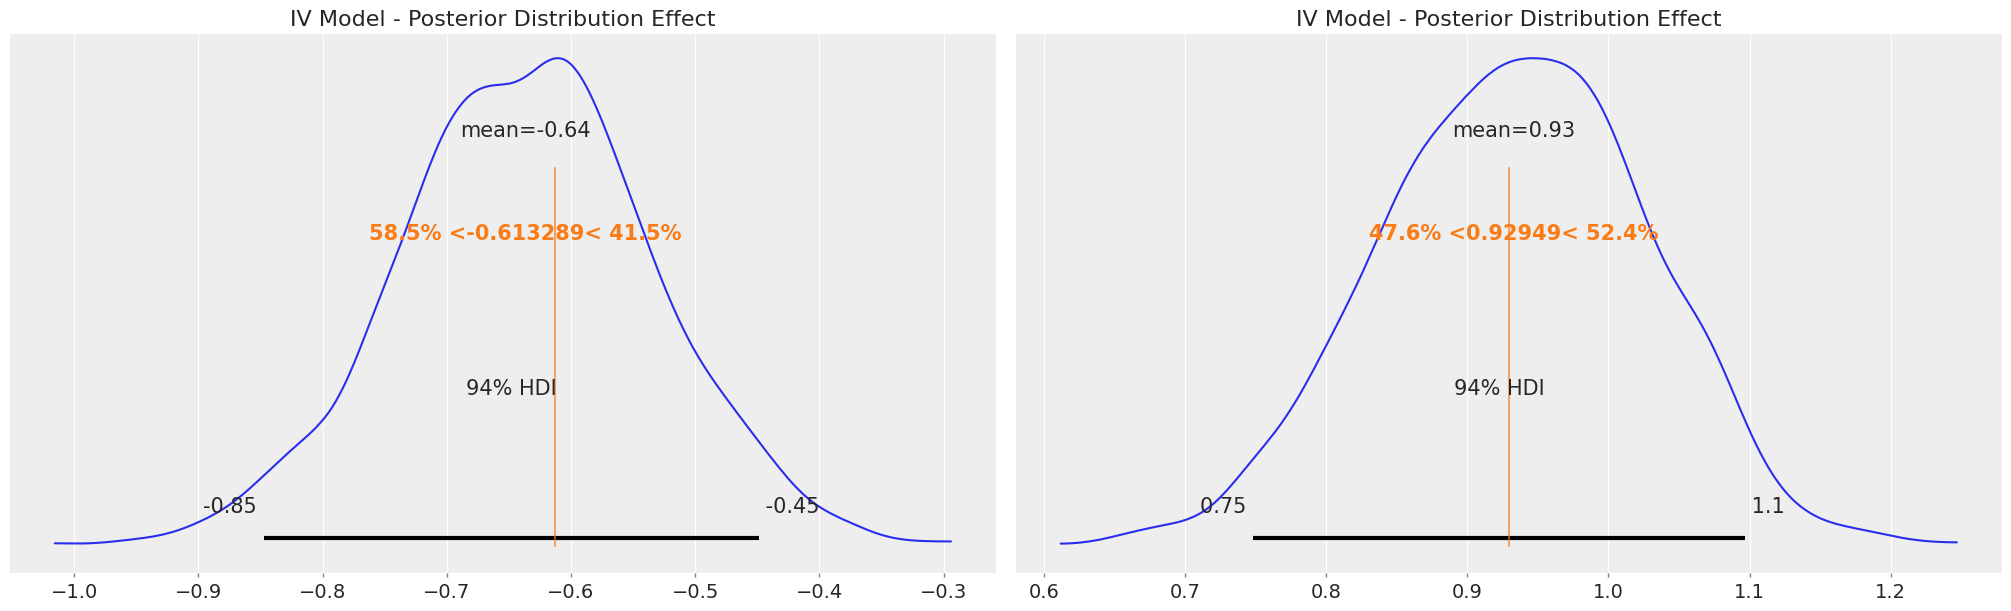

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.flatten()
ax = axs[0]
hdi_prob = 0.94
az.plot_posterior(
    data=idata_m1,
    var_names=["beta_t"],
    hdi_prob=hdi_prob,
    ref_val=ols_model_fit.params["logmort0"],
    ax=ax,
)
ax.set(title="IV Model - Posterior Distribution Effect")

az.plot_posterior(
    data=idata_m1,
    var_names=["beta_z"],
    hdi_prob=hdi_prob,
    ref_val=ols_model_iv_fit.params["risk_fitted"],
    ax=axs[1],
)
axs[1].set(title="IV Model - Posterior Distribution Effect");

<Axes: xlabel='likelihood / likelihood'>

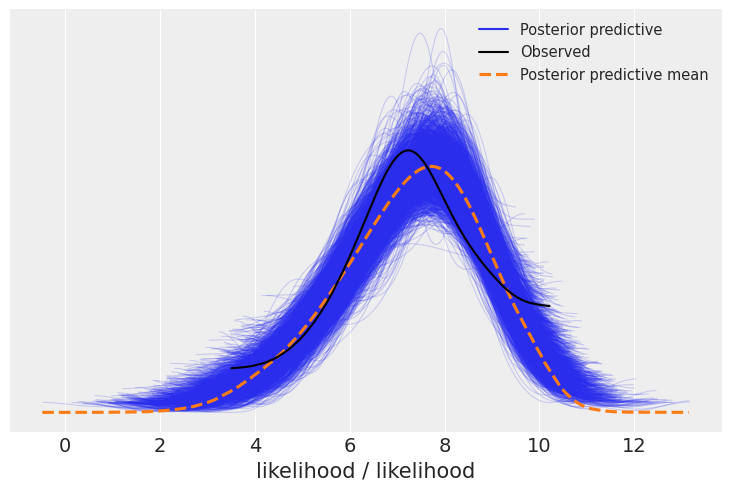

In [20]:
az.plot_ppc(idata_m1)

In [35]:
class InstrumentalVariableRegression(ModelBuilder):
    """Custom PyMC model for linear regression"""

    def build_model(self, X, Z, y, t, coords) -> None:
        # --- Priors ---
        with self:
            self.add_coords(coords)
            intercept_y = pm.Normal(name="intercept_y", mu=2, sigma=1)
            intercept_t = pm.Normal(name="intercept_t", mu=10, sigma=1)
            beta_t = pm.Normal(name="beta_t", mu=0, sigma=1, dims="instruments")
            beta_z = pm.Normal(name="beta_z", mu=0, sigma=1, dims="covariates")
            sd_dist = pm.HalfCauchy.dist(beta=2, shape=2)
            chol, corr, sigmas = pm.LKJCholeskyCov(
                name="chol_cov", eta=2, n=2, sd_dist=sd_dist
            )
            # compute and store the covariance matrix
            pm.Deterministic(name="cov", var=pt.dot(l=chol, r=chol.T))

            # --- Parameterization ---
            mu_y = pm.Deterministic(
                name="mu_y", var=pm.math.dot(X, beta_z) + intercept_y
            )
            mu_t = pm.Deterministic(
                name="mu_t", var=pm.math.dot(Z, beta_t) + intercept_t
            )
            mu = pm.Deterministic(name="mu", var=pt.stack(tensors=(mu_y, mu_t), axis=1))

            # --- Likelihood ---
            likelihood = pm.MvNormal(
                name="likelihood",
                mu=mu,
                chol=chol,
                observed=np.stack(arrays=(y, t), axis=1),
                shape=(n, 2),
            )


class InstrumentalVariable(ExperimentalDesign):
    """
    A class to analyse instrumental variable style experiments.

    :param instruments_data: A pandas dataframe of instruments for our treatment variable
    :param data: A pandas dataframe of covariates for fitting the focal regression of interest
    :param instruments_formula: A statistical model formula for the instrumental stage regression
    :param formula: A statistical model formula for the focal regression
    :param model: A PyMC model

    .. note::

        There is no pre/post intervention data distinction for the instrumental variable
        design, we fit all the data available.
    """

    def __init__(
        self,
        instruments_data: pd.DataFrame,
        data: pd.DataFrame,
        instruments_formula: str,
        formula: str,
        model=None,
        **kwargs,
    ):
        super().__init__(model=model, **kwargs)
        self.expt_type = "Instrumental Variable Regression"
        self.data = data
        self.instruments_data = instruments_data
        self.formula = formula
        self.instruments_formula = instruments_formula

        y, X = dmatrices(formula, self.data)
        self._y_design_info = y.design_info
        self._x_design_info = X.design_info
        self.labels = X.design_info.column_names
        self.y, self.X = np.asarray(y), np.asarray(X)
        self.outcome_variable_name = y.design_info.column_names[0]

        t, Z = dmatrices(instruments_formula, self.instruments_data)
        self._t_design_info = t.design_info
        self._z_design_info = Z.design_info
        self.labels_instruments = Z.design_info.column_names
        self.t, self.Z = np.asarray(t), np.asarray(Z)
        self.instrument_variable_name = t.design_info.column_names[0]

        # fit the model to the observed (pre-intervention) data
        COORDS = coords = {
            "instruments": self.labels_instruments,
            "covariates": self.labels,
        }
        self.model.fit(X=self.X, y=self.y, coords=COORDS)


instruments_formula = "risk  ~ logmort0"
formula = "loggdp ~ risk"
instruments_data = iv_df[["risk", "logmort0"]]
data = iv_df[["loggdp", "risk"]]
iv = InstrumentalVariable(
    instruments_data, data, instruments_formula, formula, InstrumentalVariableRegression
)
iv.outcome_variable_name

'loggdp'